# Handle imports

In [1]:
from dotenv import load_dotenv
import os
import cassio
from uuid import uuid4
import numpy as np
import pandas as pd
import json
import pandas as pd


from typing import Literal,List,Annotated

from langchain_core.prompts import ChatPromptTemplate,PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import AnyMessage,trim_messages,AIMessage,HumanMessage,RemoveMessage
from langchain_core.output_parsers import StrOutputParser,JsonOutputParser
from langchain_core.documents import Document


from langgraph.graph import END, START, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import add_messages

from typing_extensions import TypedDict

from transformers import BertTokenizer

load_dotenv()

d:\TAMU\SEM 4\CNM\BrokenBasket\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3549: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
d:\TAMU\SEM 4\CNM\BrokenBasket\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
unique_id = uuid4().hex[0:8]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Tracing Walkthrough - {unique_id}"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv('LANGCHAIN_API_KEY') # Update to your API key

In [3]:
from langsmith import Client
client = Client()

# Connect to the database

In [4]:
# connection of Astra DB
ASTRA_DB_APPLICATION_TOKEN = os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID = os.getenv("ASTRA_DB_ID")

cassio.init(
    token = ASTRA_DB_APPLICATION_TOKEN,
    database_id = ASTRA_DB_ID
)

In [5]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name = "all-MiniLM-L6-v2")

In [6]:
from langchain.vectorstores import Cassandra
astra_vector_store = Cassandra(embedding=embeddings,
                               table_name = "CNM_test_table",
                               session=None,
                               keyspace=None)

In [7]:
recipe_retriever = astra_vector_store.as_retriever(    
                                                search_type="similarity_score_threshold",
                                                search_kwargs={"k": 2, "score_threshold": 0.8},
                                                )   
recipe_retriever.invoke("Give me a cookie recipe")

[Document(id='f221c87e5852447eaca5168f2e4349be', metadata={'description': 'These are THE BEST soft chocolate chip cookies! No chilling required. Just ultra thick, soft, classic chocolate chip cookies!', 'language': 'en-US', 'source': 'https://pinchofyum.com/the-best-soft-chocolate-chip-cookies/print/39213', 'title': 'The Best Soft Chocolate Chip Cookies Recipe - Pinch of Yum'}, page_content='Keywords: chocolate chip cookies, best chocolate chip cookies, soft chocolate chip cookies, easy cookie recipe, small batch cookies\n\n\n\n\n\nDid you make this recipe?\nTag\xa0@pinchofyum\xa0on Instagram so we can admire your masterpiece!\xa0🌟\n\n\n\n\n\n\nFind it online: https://pinchofyum.com/the-best-soft-chocolate-chip-cookies'),
 Document(id='3af43e5c1fe84cd6a2ed6f96cd82bb7b', metadata={'description': 'These are THE BEST soft chocolate chip cookies! No chilling required. Just ultra thick, soft, classic chocolate chip cookies!', 'language': 'en-US', 'source': 'https://pinchofyum.com/the-best-s

In [10]:
# ingredients_db = pd.read_csv("database/food_with_embeddings.csv")

# Langgraph

### Datamodel

In [11]:
class GeneralRouteQuery(BaseModel):
    """ Route a user query to the most relavent datasource """
    datasource: Literal["food","general"] = Field(
        ...,
        description="Given a user question choose to route it to general chat or a food"
    )

class ToolRouteQuery(BaseModel):
    """ Route a user query to the most relavent datasource """
    datasource: Literal["meal_plan","recipe"] = Field(
        ...,
        description="Given a user question choose to route it to meal_plan or recipe"
    )

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        messages: recent message history
        preferences: uses' food preferences
        documents: list of documents
        calorie_goal: user's calorie goal
    """
    messages: Annotated[list[AnyMessage], add_messages]
    documents: List[str]
    preferences: str
    calorie_goal: int
    meal_plan: dict
    redo: str
    current_calories : int

### LLM links

In [12]:
from langchain_groq import ChatGroq
# from google.colab import userdata
import os
groq_api_key = os.getenv('groq_api_key')
# print(groq_api_key)

In [13]:
llm=ChatGroq(groq_api_key=groq_api_key,model_name='Llama-3.3-70b-Versatile')
chat_llm = ChatGroq(groq_api_key=groq_api_key,model_name='Llama-3.3-70b-Versatile')

structured_llm_general_router=llm.with_structured_output(GeneralRouteQuery)
structured_llm_tool_router=llm.with_structured_output(ToolRouteQuery)


### Prompts

In [14]:
# General router Prompt
system = """You are an expert at routing a user question to a food or general.
The food can tools to take care of meal planning, recipe finding and creation.
Use the food for questions on these topics. Otherwise, use general."""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

general_router = route_prompt | structured_llm_general_router

print(general_router.invoke({"messages": "what is stardew Valley"}))
print(general_router.invoke({"messages": "How to make a sweet dessert"}))

datasource='general'
datasource='food'


In [15]:
# tool router Prompt
system = """
You are an expert at routing a user message to a meal_plan or recipe.
the meal_plan has access to tools to generate a meal plan for your weight goals.
Use the meal_plan for questions on these topics. 
If the message has to do with finding or modifying a recipe, use recipe.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{messages}"),
    ]
)

tool_router = route_prompt | structured_llm_tool_router

print(tool_router.invoke({"messages": "how to make butter chicken"}))
print(tool_router.invoke({"messages": "help me plan the food for the week"}))

datasource='recipe'
datasource='meal_plan'


In [16]:
system = """" 
You are an expert at generating a meal plan based on a user's input such as calorie goal and food preferences.
The user's preferences are : {preferences}
The user's calorie goal for the day : {calorie_goal}

You are to take reference from the documents provided below : {documents}

You are to generate a meal plan for a day include 3 meals. The meal plan should be a JSON in the following format:

"butter chicken" : [[500,"chicken"],[100, "spices"],[50, "onion"]],
"coffee" : [[10,"coffee"],[20,"milk"]],
...

Please write 3 recipes only. For each recipe for the key write the name of the dish The contents of each recipe should be the list of ingredients used to make the recipe and the quantity.
It does not matter for breakfast, lunch and dinner, just output 3 meals pertaining to the calorie goals from the documents provided.

where the key is the name of the meal and the value is a list of lists where each list is of the form [quantity,ingredient].
Quantity should ONLY BE in grams

Return the meal plan as a JSON, DO NOT return any other text.
Make it so that the output is in 1 line.
DO not write any text before or after the brackets
"""

generate_meal_plan_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        # ("human", "{messages}"),
    ]
)

generate_meal_plan = generate_meal_plan_prompt | llm | JsonOutputParser()

# temp_mp = generate_meal_plan.invoke({"preferences": "desserts", "calorie_goal": 2000, "documents": temp_docs})

# print(temp_mp)

# print(output_json)

### Helper functions

In [17]:
def cosine(a,b):
    print(type(a))
    print(type(b))
    if a == 0 or b == 0:
        return 0
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

### nodes

In [18]:
def trim(state):
    # response = trim_messages(
    #     state["messages"],
    #     strategy="last",
    #     token_counter=len, # each message will be counted as 1 token
    #     max_tokens=1,
    #     start_on="human",
    #     end_on=("human", "tool"),
    #     include_system=True,
    # )
    if len(state['messages']) > 2:
        delete_messages = [RemoveMessage(id=m.id) for m in state['messages'][:-2]]
        return {"messages": delete_messages}
    else:
        return {"messages": state['messages']}

In [19]:
def general_chat_bot(state):
    response = chat_llm.invoke(state["messages"])
    return {"messages": response}

In [20]:
def retrieve_recipes(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    print("retrieved using the prompt: ",state["messages"][-1].content)
    
    response = recipe_retriever.invoke(state["messages"][-1].content)
    print("retrieved: ",response)
    return {"documents": response}

In [21]:
def general_route(state):
    """
    Route question to general or food.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION (GENERAL)---")
    message = state["messages"][-1].content
    # print("message: ",message)
    
    source = general_router.invoke({"messages": message})
    # print("source: ",source.datasource)
    if source.datasource == "general":
        print("---ROUTE QUESTION TO GENERAL CHAT---")
        return "general_chat_route"
    elif source.datasource == "food":
        print("---ROUTE QUESTION TO FOOD---")
        return "food_route"
    else:
        raise ValueError(f"Unknown datasource: {source.datasource}")

In [22]:
def tool_route(state):
    """
    Route question to general or food.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION (TOOLS)---")
    message = state["messages"][-1].content
    # print("message: ",message)
    
    source = tool_router.invoke({"messages": message})
    # print("source: ",source.datasource)
    if source.datasource == "meal_plan":
        print("---ROUTE QUESTION TO MEAL PLAN---")
        return "meal_plan_route"
    elif source.datasource == "recipe":
        print("---ROUTE QUESTION TO RECIPE---")
        return "recipe_route"
    else:
        raise ValueError(f"Unknown datasource: {source.datasource}")

In [23]:
def meal_plan_retriever(state):
    """"
    Create a meal plan
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): The current graph state with the meal plan added
    
    """
    print("---MEAL PLANNER RETRIEVER---")
    documents = recipe_retriever.invoke(state["preferences"])
    return ({"documents": documents})

In [24]:
def meal_plan_generator(state):
    """"
    Create a meal plan
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): The current graph state with the meal plan added
    
    """
    print("---MEAL PLANNER GENERATOR---")  
    try: 
        meal_plan = generate_meal_plan.invoke({"preferences": state["preferences"], "calorie_goal": state["calorie_goal"], "documents": state["documents"]})
    except:
        print("---MEAL PLANNER GENERATOR FAILED---")
        print("TRY AGAIN")

    return ({"meal_plan": meal_plan})

In [25]:
def general(state):
    print("reached general state")
    return state

def food(state):
    print("reached food state")
    return state

In [26]:
def meal_plan_checker(state):
    print("---CREATE MEAL PLAN---")
    meal_plan = state['meal_plan']
    current_calories = 0
    calorie_goal = state['calorie_goal']

    # encoder
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    for dish in meal_plan:
        for grams, ingredient in meal_plan[dish]:
            # vectorize ingredient
            encoded_input = tokenizer(ingredient, max_length = 50, return_tensors='pt')

            # compare to db
            most_similar = (0,"")
            for index,item in ingredients_db['embedding']:
                if cosine(item,encoded_input) > most_similar[0]:
                    most_similar = (cosine(item,encoded_input),index)

            # calculate calories
            current_calories += grams * ingredients_db['calories'][most_similar[1]]

    if current_calories > calorie_goal:
        return {"redo": True}
    else: 
        return {"redo": False, "current_calories": current_calories} 


In [27]:
def redo_meal_plan(state):
    redo = state['redo']
    if redo:
        return "redo_meal_plan"
    else:
        return "continue"

In [28]:
def display_meal_plan(state):
    print("---DISPLAY MEAL PLAN---")
    print("meal plan: ",state['meal_plan'])
    print("current calories: ",state['current_calories'])
    return state

### Graph creation

In [32]:
workflow = StateGraph(GraphState)

workflow.add_node("trim", trim)
workflow.add_node("general_router", general)
workflow.add_node("general_chat_bot", general_chat_bot)
workflow.add_node("tool_router", food)
workflow.add_node("retrieve_recipes", retrieve_recipes)
workflow.add_node("meal_plan_retriever", meal_plan_retriever)
workflow.add_node("generate_meal_plan", meal_plan_generator)
workflow.add_node("check_meal_plan", meal_plan_checker)
# workflow.add_node("redo_meal_plan_router", redo_meal_plan)
workflow.add_node("display_meal_plan", display_meal_plan)

workflow.add_edge(START, "trim")
workflow.add_edge("trim", "general_router")
workflow.add_conditional_edges(
    "general_router",
    general_route,
    {
        "general_chat_route": "general_chat_bot",
        "food_route": "tool_router",
    },
)
workflow.add_conditional_edges(
    "tool_router",
    tool_route,
    {
        "meal_plan_route": "meal_plan_retriever",
        "recipe_route": "retrieve_recipes",
    },
)
workflow.add_edge("meal_plan_retriever", "generate_meal_plan")
workflow.add_edge("generate_meal_plan", "check_meal_plan")

workflow.add_conditional_edges(
    "check_meal_plan",
    redo_meal_plan,
    {
        "redo_meal_plan": "generate_meal_plan",
        "continue": "display_meal_plan",
    },
)
workflow.add_edge("display_meal_plan", END)
workflow.add_edge("general_chat_bot", END)
workflow.add_edge("retrieve_recipes", END)
# workflow.add_edge("meal_plan", END)

memory = MemorySaver()
app = workflow.compile(checkpointer = memory)

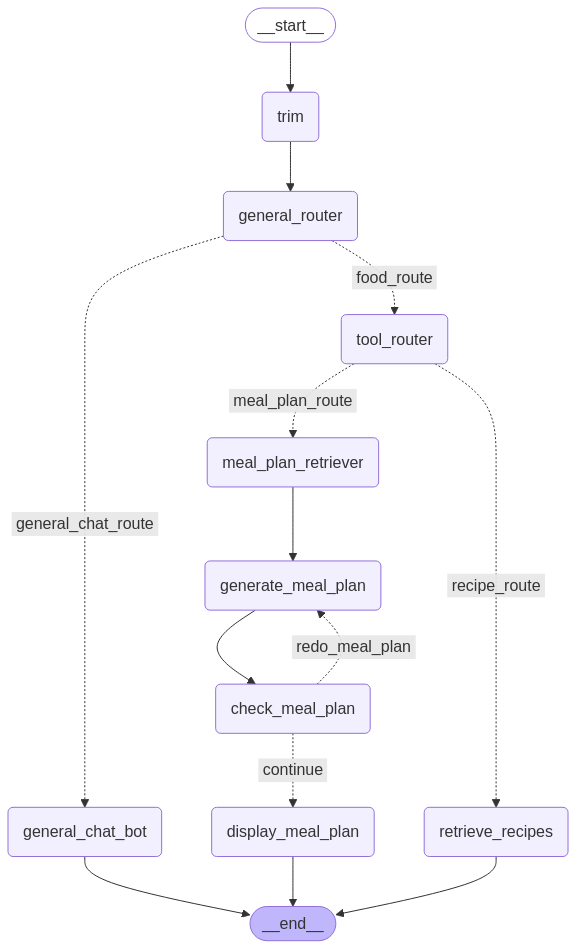

In [33]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Chat and testing

In [ ]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
# input_message = [HumanMessage(content="Hey")]
# output = app.invoke({"messages":input_message},config=config)
# output["messages"][-1].pretty_print()

In [ ]:
input_message = [HumanMessage(content="How to make butter chicken"),
                 HumanMessage(content="Help me createa meal plan for the week"),
                 HumanMessage(content="What is the capital of France")]

for input_m in input_message:
    output = app.invoke({"messages":input_m},config=config)
    output["messages"][-1].pretty_print()

reached general state
---ROUTE QUESTION (GENERAL)---
message:  How to make butter chicken
source:  food
---ROUTE QUESTION TO FOOD---
reached food state
---ROUTE QUESTION (TOOLS)---
message:  How to make butter chicken
source:  recipe
---ROUTE QUESTION TO RECIPE---
---RETRIEVE---
retrieved using the prompt:  How to make butter chicken
retrieved:  [Document(id='0a5a899762784e62804702b8cc9a6b95', metadata={'description': "This easy cake recipe requires just 7 ingredients and tastes like you spent hours making it, even though it's out of the oven in under an hour.", 'language': 'en', 'source': 'https://www.allrecipes.com/recipe/17481/simple-white-cake/?print', 'title': 'Simple White Cake Recipe'}, page_content="Worth the effort\nVery light, very great. This is my second time trying this recipe and it turned out just as amazing as the first time. Very beginner friendly, today I added some nuts on top. \n\n \n05\nof 663\n\n\n\n\n\n\n\n\n\n\n\nPhoto by\xa0\nSayeh Majzoob\n\n\n\n\n\n\n\n\n\n\n